In [1]:

import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT * FROM ebmdatalab.outlier_detection.chem_by_subpara_by_ccg_juntoaug17_limitsubpara
-- exclude non-standard CCG codes:
WHERE SUBSTR(pct,1,1) NOT BETWEEN 'A' AND 'Z' -- first character numerical
AND SUBSTR(pct,3,1) BETWEEN 'A' AND 'Z'  -- last character alphabetical
'''

df1 = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)
# rows: pct, chemical, subpara, num, denom, ratio (num and denom are items not quantity)

q2 = '''SELECT DISTINCT chemical, chemical_code from ebmdatalab.hscic.bnf'''
chem = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard',verbose=False)

q3 = '''SELECT DISTINCT subpara, subpara_code from ebmdatalab.hscic.bnf'''
subp = pd.io.gbq.read_gbq(q3, GBQ_PROJECT_ID, dialect='standard',verbose=False)

## Clean the data: sort out null denominators

In [2]:
# need to flag where ccgs have not prescribed any items of the denominator in order to clean the data. 

# Step 1: amend the datafrome to include a line for every CCG and every chemical and subparagraph.

# list all subpara-chemical combinations 
a = df1[["subpara", "chemical"]].drop_duplicates()

#list all ccgs
b = df1[["pct"]].drop_duplicates()

# cross join to make table of all CCGs and all subpara combinations 
a['tmp'] = 1
b['tmp'] = 1
c = b.merge(a, on="tmp").drop('tmp', axis=1) # 237,636 rows

# join to data - need to list every possible chemical against every CCG
data = c.merge(df1, how="left", on=["pct","subpara","chemical"])  # 237,636 rows
data


# Step 2: identify those with zero subparas
# subpara totals by ccg
subpara = df1[["pct","subpara","denom"]].groupby(["subpara","pct"]).max().reset_index() # 42,917 rows

#list all possible subparagraphs and all ccgs
a2 = df1[["subpara"]].drop_duplicates()
a2['tmp'] = 1

# cross join to CCGs to make table of all CCGs and all subpara combinations 
c2 = b.merge(a2, on="tmp").drop('tmp', axis=1) # 56,097 rows

# join to subpara data by ccg to identify subparas prescribed by each ccg.  
d = c2.merge(subpara,how="left", on=["subpara","pct"])

# for subparas never prescribed, replace NAs with zeros so that there is data present to indicate this
d = d.fillna(0)

# join back to original dataset
d2 = d.merge(data, how="left", on=["subpara","pct"], suffixes=("_subpara",""))
# check how many have zero denominators:
# data.loc[(data["denom_subpara"]==0)] # 19,665 rows 

# exclude combinations where denominators are zero THEN replace NAs with 0:
data2 = d2.loc[(d2["denom_subpara"]!=0)]
data2 = data2.fillna(0)


### Filter out low numbers (chemical and subpara)

In [3]:
# total prescribing for each chemical
#sum numerators to find total volume for each chemical
num = pd.DataFrame(df1["num"].groupby(df1["chemical"]).sum()).reset_index()
num["num centile"] = pd.qcut(num["num"], 10, labels=np.arange(1,11,1))
num.head()

# total prescribing for each paragraph
d3 = d2[["pct","subpara","denom_subpara"]].drop_duplicates()
d3 = d3.groupby("subpara").sum().sort_values(by="denom_subpara")
d3["denom centile"] = pd.qcut(d3["denom_subpara"], 10, labels=np.arange(1,11,1))
d3 = d3.reset_index()


# merge with data table
data3 = data2.merge(num, how="inner", on="chemical",suffixes=("","_total"))
data3 = data3.merge(d3, how="inner", on="subpara",suffixes=("","_total"))
data3 = data3.loc[(data3["denom centile"]>2) & (data3["num centile"]>2)]
data3.head()

,pct,subpara,denom_subpara,chemical,num,denom,ratio,num_total,num centile,denom_subpara_total,denom centile
0,10C,1202030,203.0,1202030R0,35.0,203.0,0.172414,21681,7,117303.0,5
1,10D,1202030,210.0,1202030R0,23.0,210.0,0.109524,21681,7,117303.0,5
2,10E,1202030,216.0,1202030R0,27.0,216.0,0.125000,21681,7,117303.0,5
3,10G,1202030,320.0,1202030R0,32.0,320.0,0.100000,21681,7,117303.0,5
4,10H,1202030,753.0,1202030R0,144.0,753.0,0.191235,21681,7,117303.0,5


## Calculate key stats
### Median, Range, SD

In [4]:
#select columns of interest and get key stats
df2 = pd.DataFrame(data3.groupby(["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile"])["ratio"].describe())
df2 = df2.unstack()
df2.columns = df2.columns.droplevel()

df3 = df2.reset_index()
df3["range"] = df3["max"] - df3["min"]
df3 = df3[["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile","count","50%","min","max","range","std"]].rename(columns={"50%":"median"})

# filter out chemicals only prescribed by few CCGs
df3 = df3.loc[df3["count"]>=50]
df3.head()

,chemical,subpara,num_total,num centile,denom_subpara_total,denom centile,count,median,min,max,range,std
0,0101010C0,0101010,1423,5,39497.0,4,192.0,0.013179,0.000000,0.340426,0.340426,0.069412
1,0101010F0,0101010,119,3,39497.0,4,192.0,0.000000,0.000000,0.185629,0.185629,0.017496
2,0101010G0,0101010,19759,7,39497.0,4,192.0,0.440633,0.081081,0.912442,0.831361,0.186258
3,0101010I0,0101010,1050,4,39497.0,4,192.0,0.016001,0.000000,0.294872,0.294872,0.049069
4,0101010J0,0101010,984,4,39497.0,4,192.0,0.018857,0.000000,0.162162,0.162162,0.027994


### Kurtosis & Skew 
Need to import stats module and reshape data

In [5]:
# reshape data to put CCGs in columns
df5 = data3.pivot(index="chemical",columns='pct', values='ratio')

#calculate kurtosis and skew for each chemical
import scipy.stats as stats
k = pd.Series(stats.kurtosis(df5, axis=1,nan_policy="omit"),name="kurtosis")
sk =  pd.Series(stats.skew(df5, axis=1,nan_policy="omit"),name="skew")


### Compile stats up

In [6]:

result = pd.concat([df3, k, sk], axis=1).sort_values(by="kurtosis",ascending=False)
result = result[["chemical","subpara", "count","num_total","num centile","median","min","max","range","std","kurtosis","skew"]].round(2)

# Lookup chemical and subparagraph names
df4 = result.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
df4 = df4.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
df4 = df4[["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"]].round(2)
df4.head()

C:\Users\hcurtis\Anaconda2\lib\site-packages\pandas\core\series.py:1342: RuntimeWarning: invalid value encountered in rint
  result = _values_from_object(self).round(decimals)


,chemical,chemical name,subpara,subpara name,num_total,num centile,count,median,min,max,range,std,kurtosis,skew
0,0501012G0,Flucloxacillin Sodium,0501012,Penicillinase-Resistant Penicillins,1058061.0,10.0,207.0,1.0,1.00,1.00,0.00,0.0,202.00,-14.28
1,0109040N0,Pancreatin,0109040,Pancreatin,131281.0,9.0,207.0,1.0,1.00,1.00,0.00,0.0,202.00,-14.28
2,1404000AP,NaN,1404000,Vaccines And Antisera,155.0,3.0,207.0,0.0,0.00,0.05,0.05,0.0,194.36,13.90
3,0405010P0,Orlistat,0405010,Gastro-Intestinal Anti-Obesity Drugs,106235.0,9.0,203.0,1.0,0.99,1.00,0.01,0.0,176.71,-13.11
4,0402010C0,Clozapine,0402010,Antipsychotic Drugs,768.0,4.0,207.0,0.0,0.00,0.02,0.02,0.0,172.99,12.82


## Ranking Chemicals by Range, Kurtosis, Skew and SD

In [7]:
# sort by range first
r1 = df4.sort_values(by=["range","kurtosis"],ascending=False).head(20)
# create a flag
r1["R"] = 1

# sort by kurtosis and limit to items with at least 1% range 
r2 = df4.loc[(df4["range"] >0.1)].sort_values(by=["kurtosis"],ascending=False).head(20)
r2["K"] = 1

# sort by skew
r3 = df4.loc[(df4["range"] >0.1)].sort_values(by=["skew"],ascending=False).head(20)
r3["Sk"] = 1

#sort by SD
r4 = df4.loc[(df4["range"] >0.1)].sort_values(by=["std"],ascending=False).head(20)
r4["SD"] = 1
r4

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,median,min,max,range,std,kurtosis,skew,SD
1125,0208010D0,Enoxaparin,0208010,Parenteral Anticoagulants,44906.0,8.0,204.0,0.34,0.00,1.00,0.99,0.36,-1.62,0.23,1
933,1501030G0,Glycopyrronium Bromide,1501030,Antimuscarinic Drugs,14241.0,7.0,108.0,0.96,0.00,1.00,1.00,0.34,0.17,-1.34,1
932,1501030H0,Hyoscine Hydrobromide,1501030,Antimuscarinic Drugs,5035.0,6.0,108.0,0.03,0.00,1.00,1.00,0.34,0.17,1.35,1
1124,0208010L0,Dalteparin Sodium,0208010,Parenteral Anticoagulants,33908.0,8.0,204.0,0.16,0.00,0.98,0.98,0.33,-1.18,0.66,1
819,0208010W0,Tinzaparin Sodium,0208010,Parenteral Anticoagulants,17389.0,7.0,204.0,0.04,0.00,0.98,0.98,0.28,0.91,1.54,1
1119,0301040W0,Umeclidinium Brom/Vilanterol,0301040,Compound Bronchodilator Preparations,83940.0,8.0,205.0,0.37,0.00,0.93,0.92,0.24,-1.01,0.19,1
1112,1302020D0,Dimeticone (Barrier),1302020,Barrier Preparations,79048.0,8.0,207.0,0.34,0.02,0.91,0.89,0.23,-0.80,0.43,1
1108,0905022C0,Calcium Acetate,0905022,Phosphate Binding Agents,17193.0,7.0,196.0,0.44,0.00,0.96,0.96,0.22,-0.70,-0.02,1
1027,0905022S0,Sevelamer,0905022,Phosphate Binding Agents,20729.0,7.0,196.0,0.41,0.01,0.97,0.96,0.21,-0.23,0.49,1
917,0410030C0,Methadone Hydrochloride,0410030,Opioid Dependence,108891.0,9.0,176.0,0.61,0.00,0.95,0.95,0.20,0.27,-0.80,1


### Results compiled and with Hyperlinks to maps

In [14]:
# compile top 20 from each sort into a single output

rc = pd.merge(r1, r2, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
rc = rc.merge(r3, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
rc = rc.merge(r4, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer").fillna(0)  

rc["score"] = rc["R"]+rc["K"]+rc["Sk"]+rc["SD"]
rc = rc.sort_values(by=["score","range","kurtosis"],ascending=False)


links = rc
links["str"] = links["subpara"].str[0:2].map(int).map(str)+"."+links["subpara"].str[2:4].map(int).map(str)+"."+links["subpara"].str[4:6].map(int).map(str)
links["link"] = "https://openprescribing.net/analyse/#org=CCG&numIds="+links["chemical"]+"&denomIds="+links["str"]+"&selectedTab=map"
links = links.drop("str",axis=1)
#https://openprescribing.net/analyse/#org=CCG&numIds=100302010&denomIds=10.3.2&selectedTab=map
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

#links["clickable"] = 
pd.DataFrame(links).style.format(make_clickable, subset=['link'])

### Histograms

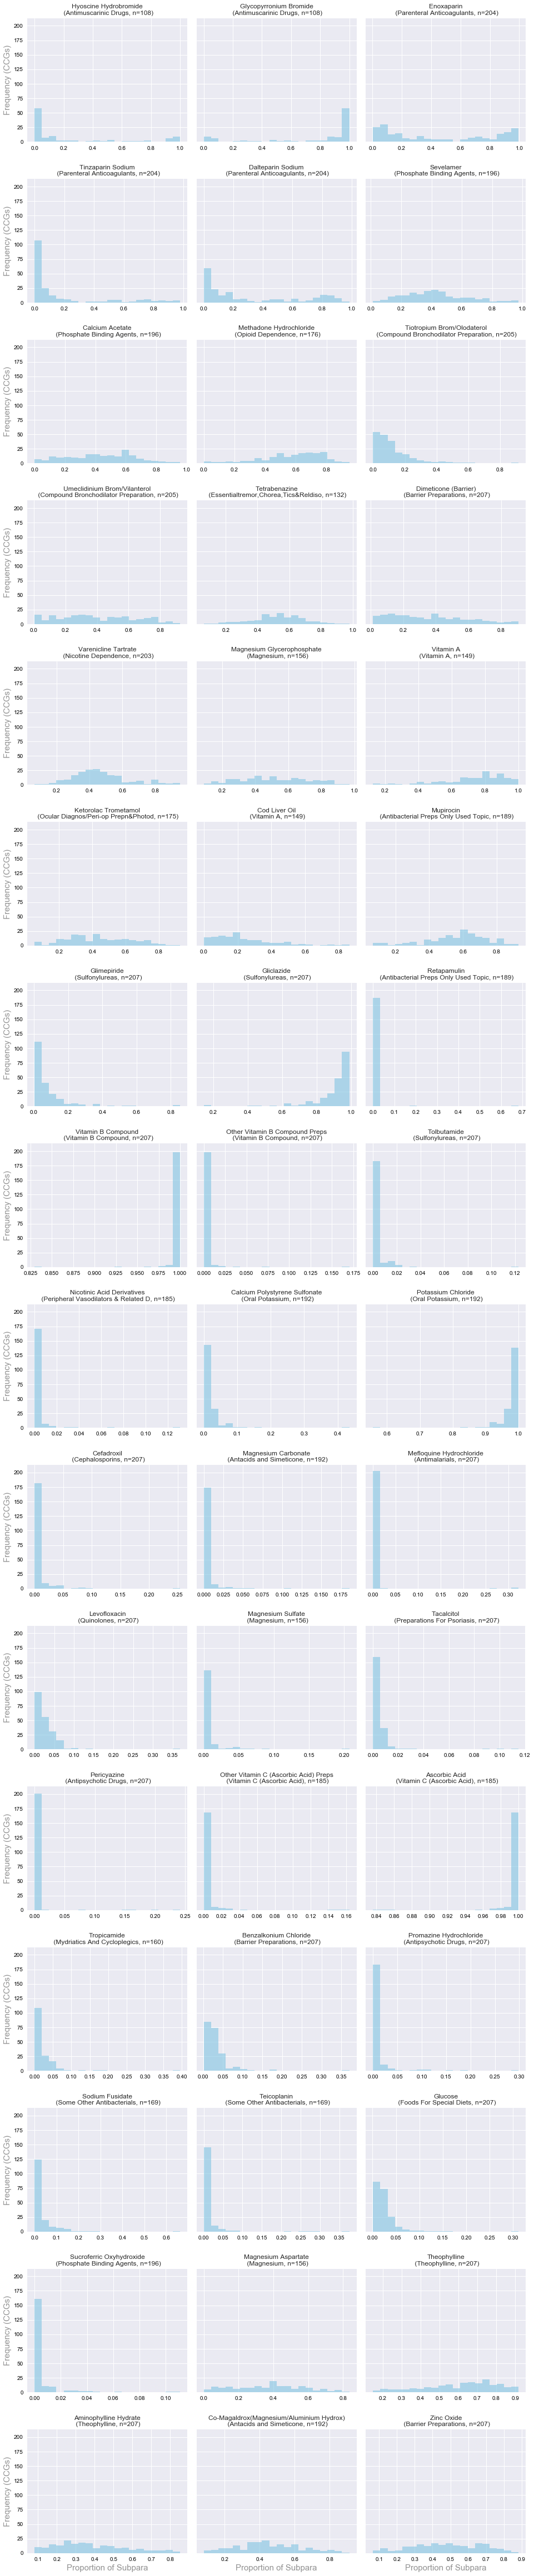

In [76]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = rc[["chemical","chemical name","subpara name"]].merge(data2[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+"\n"+" ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Histograms for top 40 chemicals by Kurtosis

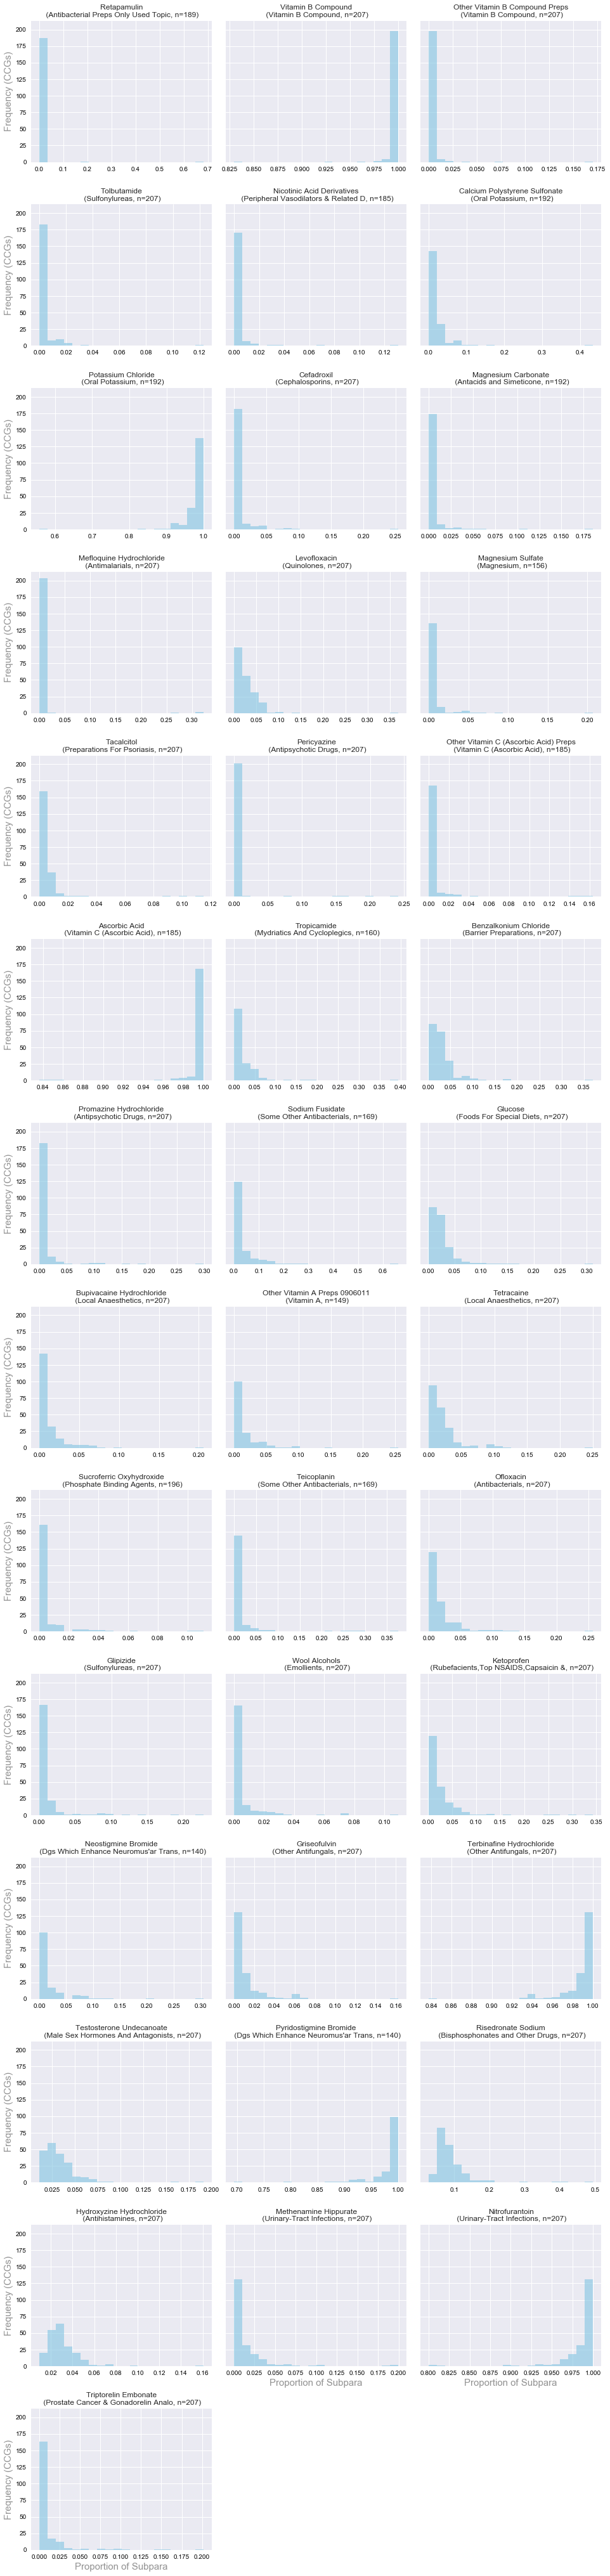

In [16]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = df4.loc[(df4["range"] >0.1) & (df4["num centile"]>2)].sort_values(by=["kurtosis"],ascending=False).head(40)
dfh = dfh[["chemical","chemical name","subpara name"]].merge(data2[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+"\n"+" ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

## Paragraph Rankings
Which paragraphs occur most often in the list of interesting chemicals?

In [54]:
para = rc.groupby(["subpara","subpara name"])["score"].agg(["count","sum"]).sort_values(by=["count","sum"],ascending=False)
para.loc[para["count"]>1]

,,count,sum
subpara,subpara name,,
0208010,Parenteral Anticoagulants,3,6.0
0905013,Magnesium,3,5.0
0905022,Phosphate Binding Agents,3,5.0
1302020,Barrier Preparations,3,5.0
0601021,Sulfonylureas,3,4.0
0402010,Antipsychotic Drugs,2,4.0
0906011,Vitamin A,2,4.0
1310011,Antibacterial Preps Only Used Topically,2,4.0
1501030,Antimuscarinic Drugs,2,4.0


## CCG Rankings
### All chemicals

In [9]:
dftest = data2#.head(1000)
dftest
#df5 = pd.qcut(series, 10, labels=np.arange(1,11,1))
dftest["rank"] = dftest.groupby(["chemical"])["ratio"].rank(pct=True)
#dftest.groupby(["pct"])["ratio"].sum()
#dftest.loc[dftest["chemical"]=="0101010C0"].sort_values(by=["chemical","rank"])

x = dftest.loc[(dftest["rank"]<=0.05) | (dftest["rank"]>=0.95)]
x2 = x.groupby("pct")["rank"].count()
print x2.sort_values(ascending=False).head(10)
print x2.sort_values().head(10)

pct
02W    263
03V    202
08V    190
99C    182
10T    182
03Y    177
07T    168
00N    164
03X    164
03H    161
Name: rank, dtype: int64
pct
06N    50
99H    51
06K    54
09Y    54
07H    55
09G    56
99N    56
06H    58
13P    58
06F    59
Name: rank, dtype: int64


### Ranking CCGs for the list of interesting chems only, by Distance from Median

In [18]:
dftest = rc[["chemical","chemical name","subpara name","min","max","range","median"]].merge(data2, on="chemical")
#dftest["rank"] = dftest.groupby(["chemical"])["ratio"].rank(pct=True)
dftest["abs diff"] = abs(dftest["ratio"]-dftest["median"])/dftest["range"]
dftest["rank abs diff"] = dftest.groupby(["chemical"])["abs diff"].rank(pct=True)
dftest.sort_values(by=["chemical","rank abs diff"])

#x0 = dftest.loc[(dftest["rank abs diff"]<=0.05)]# & (dftest["median"]>0)]
x1 = dftest.loc[(dftest["rank abs diff"]>=0.95)]# & (dftest["median"]<1)] 
x2 = x1#x0.append(x1)
x2 = x2.groupby("pct")["abs diff"].agg(["count","mean"])
x2.sort_values(by=["count","mean"],ascending=False).head(12)



,count,mean
pct,,
00T,9,0.527743
02W,7,0.668962
08H,7,0.454670
07L,7,0.348686
01A,6,0.661089
02R,6,0.573655
06M,6,0.543001
02N,6,0.494352
08E,6,0.425479


### Investigate example CCG

In [21]:
x3 = x1[["pct","chemical"]].merge(dftest, how="inner", on=["pct","chemical"]).drop(["subpara","denom","range"], axis=1)
x3.loc[x3["pct"]=="00T"].sort_values(by=["rank abs diff","abs diff"],ascending=False)

,pct,chemical,chemical name,subpara name,min,max,median,denom_subpara,num,ratio,rank,abs diff,rank abs diff
210,00T,0402010S0,Promazine Hydrochloride,Antipsychotic Drugs,0.00,0.30,0.00,18602.0,5555.0,0.298624,1.000000,0.995413,1.000000
343,00T,0601021A0,Glimepiride,Sulfonylureas,0.00,0.85,0.04,12636.0,5822.0,0.460747,0.980676,0.494997,0.980676
354,00T,0601021M0,Gliclazide,Sulfonylureas,0.14,0.99,0.94,12636.0,6748.0,0.534030,0.024155,0.477612,0.980676
181,00T,0501120X0,Levofloxacin,Quinolones,0.00,0.37,0.02,670.0,50.0,0.074627,0.980676,0.147640,0.980676
272,00T,090603100,Other Vitamin C (Ascorbic Acid) Preps,Vitamin C (Ascorbic Acid),0.00,0.16,0.00,74.0,2.0,0.027027,0.978378,0.168919,0.978378
457,00T,0906031C0,Ascorbic Acid,Vitamin C (Ascorbic Acid),0.84,1.00,1.00,74.0,72.0,0.972973,0.027027,0.168919,0.978378
112,00T,110802070,Ketorolac Trometamol,Ocular Diagnos/Peri-op Prepn&Photodyn Tt,0.05,0.93,0.42,133.0,7.0,0.052632,0.005714,0.422263,0.971429
2,00T,1501030H0,Hyoscine Hydrobromide,Antimuscarinic Drugs,0.00,1.00,0.03,107.0,104.0,0.971963,0.962963,0.941963,0.962963
8,00T,1501030G0,Glycopyrronium Bromide,Antimuscarinic Drugs,0.00,1.00,0.96,107.0,3.0,0.028037,0.046296,0.931963,0.962963


## 99P

In [20]:
dftest.loc[dftest["pct"]=="99P"].sort_values(by=["rank abs diff"],ascending=False).head(12)

,chemical,chemical name,subpara name,min,max,range,median,pct,subpara,denom_subpara,num,denom,ratio,rank,abs diff,rank abs diff
3380,0501120X0,Levofloxacin,Quinolones,0.00,0.37,0.37,0.02,99P,0501120,2136.0,788.0,2136.0,0.368914,1.000000,0.943010,1.000000
4609,0905013N0,Magnesium Sulfate,Magnesium,0.00,0.21,0.21,0.00,99P,0905013,436.0,17.0,436.0,0.038991,0.948718,0.185671,0.948718
2661,1310011AA,Retapamulin,Antibacterial Preps Only Used Topically,0.00,0.68,0.68,0.00,99P,1310011,890.0,5.0,890.0,0.005618,0.910053,0.008262,0.910053
19,1501030H0,Hyoscine Hydrobromide,Antimuscarinic Drugs,0.00,1.00,1.00,0.03,99P,1501030,1099.0,728.0,1099.0,0.662420,0.833333,0.632420,0.833333
127,1501030G0,Glycopyrronium Bromide,Antimuscarinic Drugs,0.00,1.00,1.00,0.96,99P,1501030,1099.0,371.0,1099.0,0.337580,0.175926,0.622420,0.833333
2846,0501070N0,Sodium Fusidate,Some Other Antibacterials,0.00,0.66,0.66,0.01,99P,0501070,516.0,30.0,516.0,0.058140,0.828402,0.072939,0.828402
8841,0905022W0,Sucroferric Oxyhydroxide,Phosphate Binding Agents,0.00,0.11,0.11,0.00,99P,0905022,742.0,3.0,742.0,0.004043,0.811224,0.036756,0.811224
2145,110802070,Ketorolac Trometamol,Ocular Diagnos/Peri-op Prepn&Photodyn Tt,0.05,0.93,0.87,0.42,99P,1108020,333.0,225.0,333.0,0.675676,0.868571,0.293880,0.800000
5547,0601021X0,Tolbutamide,Sulfonylureas,0.00,0.12,0.12,0.00,99P,0601021,35221.0,142.0,35221.0,0.004032,0.787440,0.033597,0.787440
6146,0409030C0,Tetrabenazine,"Essentialtremor,Chorea,Tics&Reldisorders",0.06,0.98,0.91,0.53,99P,0409030,343.0,249.0,343.0,0.725948,0.909091,0.215327,0.772727


- charts x
- better ccg ranking x
- create table of links x
- change the query so it only limits by subpara >n rather than chemical x
- practice level
- better chemical ranking (logs?)
